# Jupyter Notebook Apresentação?

In [1]:
from IPython.display import Image

%matplotlib inline
import matplotlib.pyplot as plt

import librosa.display

##  Exemplo básico de funcionamento
Vamos escrever essa classe ASRDecoder pra fazer esse exemplo e principalmente pra gerar algumas imagens da parte que está no número/capítulo

In [2]:
from ASRDecoder.decoder import Model
from ASRDecoder.param import KaldiParam

#zip criado pelo script de treinamento, deve estar no mesmo diretorio que o notebook
model_file = 'asr_train_commonvoice_transformer_fbank_pitch_char_valid.acc.best.zip'
#arquivo de audio para testes deve ser 16kHz
audio_file = 'teste_pesquisa.wav'

#carrega o modelo
model = Model(model_file)

results = model.process(audio_file) 
print("Ref: pesquisa é uma coisa que muda toda hora")
print(f"Hyp: {results.transcription}")

Loading model config from exp/asr_train_commonvoice_transformer_fbank_pitch_char/config.yaml
Loading model state from exp/asr_train_commonvoice_transformer_fbank_pitch_char/100epoch.pth
Ref: pesquisa é uma coisa que muda toda hora
Hyp: pesquisa é uma coisa que muda toda algura


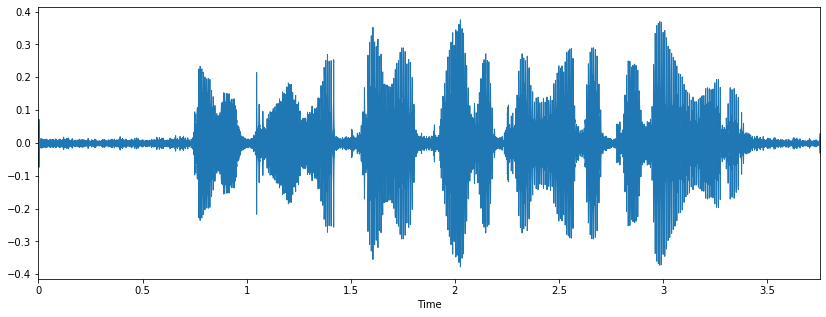

In [3]:
x, sr = librosa.load(audio_file)
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)

(373, 83)


array([[ 1.18960447e+01,  1.35496273e+01,  1.34472008e+01, ...,
        -2.62796097e-02, -3.32164764e-01, -2.32437961e-02],
       [ 1.25744801e+01,  1.22813768e+01,  1.11974754e+01, ...,
        -1.90104455e-01, -4.36467171e-01,  1.04788495e-02],
       [ 1.25171318e+01,  1.33562050e+01,  1.29578876e+01, ...,
        -3.27448756e-01, -7.18858719e-01,  6.96045253e-03],
       ...,
       [ 9.89480972e+00,  1.01875257e+01,  8.88325787e+00, ...,
         3.56980413e-02,  4.34283257e-01, -2.68898793e-02],
       [ 1.06007090e+01,  1.11317482e+01,  1.11728029e+01, ...,
         1.63745992e-02,  4.42837715e-01, -7.60403508e-03],
       [ 1.18054485e+01,  1.22630777e+01,  1.19427586e+01, ...,
         5.04715815e-02,  4.51222420e-01, -2.08791718e-02]], dtype=float32)

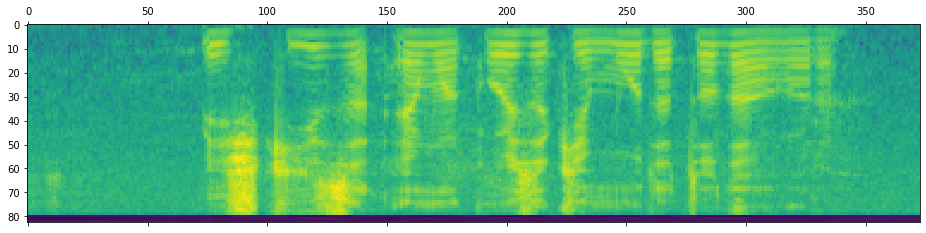

In [4]:
fbank_pitch = results.input_data
print(fbank_pitch.shape)
plt.matshow(fbank_pitch.T)
fbank_pitch

torch.Size([92, 512])


tensor([[ 0.3125,  0.4774, -0.3890,  ..., -1.1885,  1.5011, -0.2679],
        [ 0.4249,  0.2655, -0.4004,  ..., -1.0683,  1.5905, -0.1961],
        [ 0.3936,  0.7179, -0.4241,  ..., -1.1159,  1.6526, -0.1096],
        ...,
        [ 0.0966, -0.5455, -0.2081,  ..., -1.3635,  1.1157,  0.1685],
        [-0.0048, -0.5993, -0.1667,  ..., -1.2758,  1.1322,  0.0900],
        [ 0.0145, -0.4714, -0.1353,  ..., -1.3242,  1.2105,  0.1036]])

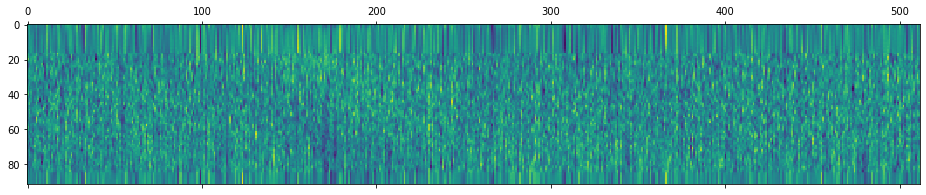

In [6]:
enc = results.encoded_vector
print(enc.shape)
plt.matshow(enc.detach().numpy())
enc

In [7]:
results.attention_weights.keys()

dict_keys(['encoder.encoders.0.self_attn', 'encoder.encoders.1.self_attn', 'encoder.encoders.2.self_attn', 'encoder.encoders.3.self_attn', 'encoder.encoders.4.self_attn', 'encoder.encoders.5.self_attn', 'encoder.encoders.6.self_attn', 'encoder.encoders.7.self_attn', 'encoder.encoders.8.self_attn', 'encoder.encoders.9.self_attn', 'encoder.encoders.10.self_attn', 'encoder.encoders.11.self_attn', 'decoder.decoders.0.self_attn', 'decoder.decoders.0.src_attn', 'decoder.decoders.1.self_attn', 'decoder.decoders.1.src_attn', 'decoder.decoders.2.self_attn', 'decoder.decoders.2.src_attn', 'decoder.decoders.3.self_attn', 'decoder.decoders.3.src_attn', 'decoder.decoders.4.self_attn', 'decoder.decoders.4.src_attn', 'decoder.decoders.5.self_attn', 'decoder.decoders.5.src_attn'])

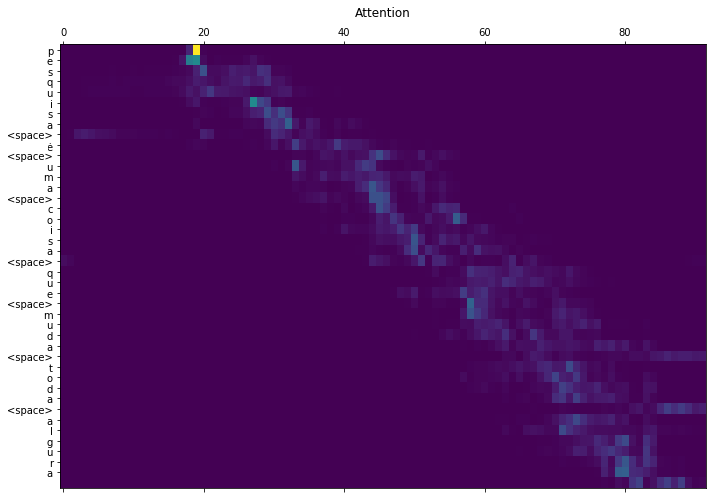

In [8]:
#apenas um exemplo, tem 12 camadas de encoder e 6 de decoder, cada uma com 8 attention heads, totalizando
#esse exemplo é o 7 attention head, da 6 camada do decoder
#Seria legal ter um widget interact pra selecionar essas opções, pq são (12+6)x8 = 144 possíveis plots
attn = results.attention_weights['decoder.decoders.5.src_attn'][0][7]

fig, ax = plt.subplots(1, figsize=(10, 7))
ax.set_title("Attention")
ax.matshow(attn, aspect="auto")
ax.set_yticks(range(len(results.tokens_txt)))
ax.set_yticklabels(results.tokens_txt)
fig.tight_layout()

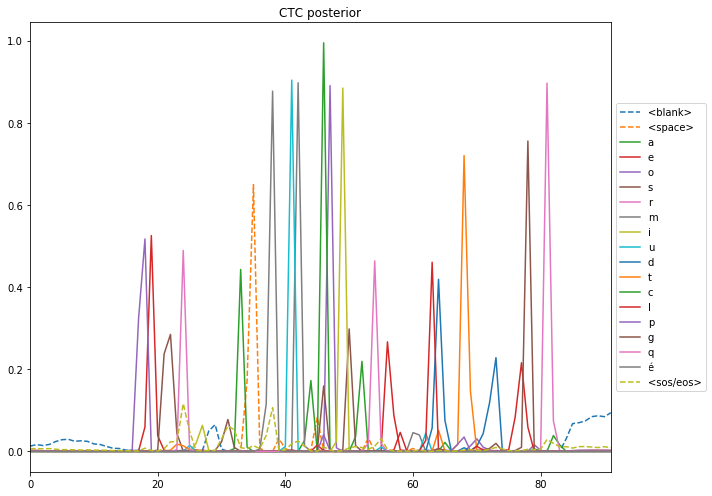

In [28]:
prob = results.ctc_posteriors[0]

fig, ax = plt.subplots(1, figsize=(10, 7))
ax.set_title("CTC posterior")
vs = set(results.tokens_int.tolist())
vs.add(0)
for n, i in enumerate(vs):
    v = model.converter.ids2tokens([i])[0]
    ax.plot(prob[:, i], label=v, linestyle="-" if len(v) == 1 else "--")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlim(0, len(enc)-1)
fig.tight_layout()


## 1 A Tarefa ASR


## 2 Os Conjuntos de dados
### 2.1 Alcaim
### 2.2 LapsBM
### 2.3 Sid
### 2.4 Voxforge
### 2.5 CommonVoice
### 2.6 Explorando os dados


## 3 Os atributos
### 3.1 Fbank
### 3.1 Pitch
### 3.3 Data Augmentation
#### 3.3.1 Specaug
#### 3.3.2 Speed Perturbation
### 3.4 Raw Audio (ESPNet Frontend (mel fbank sem pitch))


## 4 O Modelo
### 4.1 Encoder
#### 4.1.1 Encoder RNN
#### 4.1.2 Encoder VGGLike+RNN
#### 4.1.3 Encoder Transformer
### 4.2 Decoder
#### 4.2.1 Decoder RNN+att
#### 4.2.2 Decoder Transformer
### 4.3 CTC Connectionist temporal Classification
#### 4.3.1 BILSTM
#### 4.3.2 CTC Loss
##### 4.3.2.1 Trellis
##### 4.3.2.2 Dynamic Programming
### 4.4 Attention
#### 4.4.1 Transformer attention
##### 4.4.1.1 Dot Product Attention


## 4 Treinamentos


## 5 Exemplo step-by-step
### 5.1 Carrega Audio
### 5.2 Extrai Features
### 5.3 O vetor de embeddings
### 5.4 Attention Weights
### 5.5 CTC Posteriors
### 5.6 BeamSearch, Hipoteses e Resultados

## 6 Considerações







## 1 A Tarefa ASR

Donec iaculis quam rhoncus lorem dignissim venenatis. Morbi metus odio, ornare a dui sed, volutpat malesuada eros. Curabitur sit amet pellentesque eros, nec lacinia sem. Pellentesque vulputate, mauris ac sollicitudin efficitur, ante lacus auctor arcu, sit amet suscipit ligula nunc fringilla dolor. Donec sit amet neque eget nisi posuere blandit vitae ac ante. Nulla leo ipsum, hendrerit in enim at, pharetra posuere quam. Suspendisse luctus varius dui id pellentesque. Nam tincidunt volutpat turpis, ut commodo magna efficitur ac. Ut ornare ante id nibh bibendum, a semper ipsum condimentum. Sed vitae sollicitudin felis. Sed eget ante aliquam, fermentum felis auctor, vestibulum ipsum. Nam gravida libero vitae mi accumsan tempor. Nullam placerat sed metus imperdiet lobortis. Curabitur bibendum est dolor, nec lobortis odio vehicula a.


## 2 Os Conjuntos de dados

### 2.1 Alcaim

### 2.1.1 Explorando os dados
    Mostrar histogramas de duração dos trechos
    Mostrar histogramas de caracteres ou BPE (talvez não)

### 2.2 LapsBM

### 2.2.1 Explorando os dados
    Mostrar histogramas de duração dos trechos
    Mostrar histogramas de caracteres ou BPE (talvez não)

### 2.3 Sid

### 2.3.1 Explorando os dados
    Mostrar histogramas de duração dos trechos
    Mostrar histogramas de caracteres ou BPE (talvez não)

### 2.4 Voxforge

### 2.4.1 Explorando os dados
    Mostrar histogramas de duração dos trechos
    Mostrar histogramas de caracteres ou BPE (talvez não)

### 2.5 CommonVoice

### 2.5.1 Explorando os dados
    Mostrar histogramas de duração dos trechos
    Mostrar histogramas de caracteres ou BPE (talvez não)



## 3 Os atributos

Vivamus rhoncus vitae enim a rutrum. Curabitur porta dolor nec egestas auctor. Mauris luctus arcu et purus pharetra euismod. Aliquam porttitor felis risus, et sollicitudin magna sodales a. Etiam turpis massa, bibendum nec gravida in, elementum et elit. In tortor mi, rutrum eget nisl sit amet, pharetra cursus nisi. In dignissim, nunc sed ultrices mollis, felis nisl ultricies urna, at efficitur dui lectus et nisi. Vivamus quis ornare mi. Duis massa mauris, tempor sit amet bibendum quis, fermentum eget nisi.


### 3.1 Fbank

Vivamus rhoncus vitae enim a rutrum. Curabitur porta dolor nec egestas auctor. Mauris luctus arcu et purus pharetra euismod. Aliquam porttitor felis risus, et sollicitudin magna sodales a. Etiam turpis massa, bibendum nec gravida in, elementum et elit. In tortor mi, rutrum eget nisl sit amet, pharetra cursus nisi. In dignissim, nunc sed ultrices mollis, felis nisl ultricies urna, at efficitur dui lectus et nisi. Vivamus quis ornare mi. Duis massa mauris, tempor sit amet bibendum quis, fermentum eget nisi.




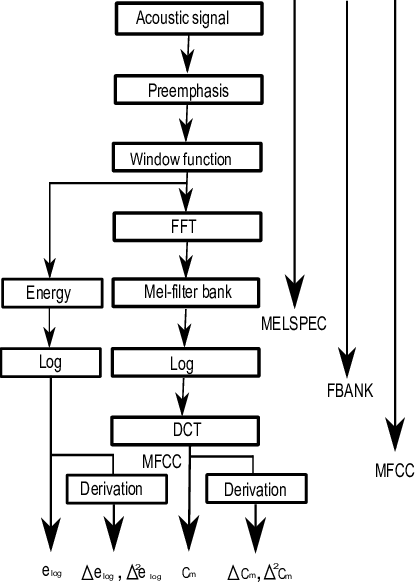

In [3]:
Image("img/features.png")

### 3.2 Pitch

https://danielpovey.com/files/2014_icassp_pitch.pdf

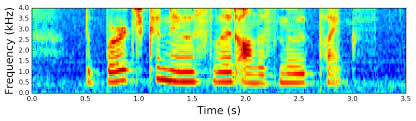

In [4]:
Image("img/featured_signal.jpg")

### 3.3 Data Augmentation

#### 3.3.1 Specaug
https://arxiv.org/pdf/1904.08779

Vivamus rhoncus vitae enim a rutrum. Curabitur porta dolor nec egestas auctor. Mauris luctus arcu et purus pharetra euismod. Aliquam porttitor felis risus, et sollicitudin magna sodales a. Etiam turpis massa, bibendum nec gravida in, elementum et elit. In tortor mi, rutrum eget nisl sit amet, pharetra cursus nisi. In dignissim, nunc sed ultrices mollis, felis nisl ultricies urna, at efficitur dui lectus et nisi. Vivamus quis ornare mi. Duis massa mauris, tempor sit amet bibendum quis, fermentum eget nisi.



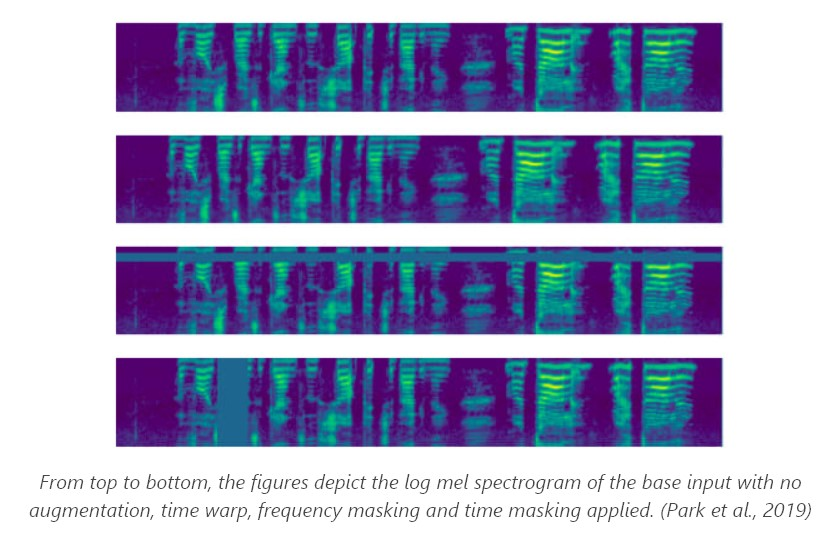

In [5]:
Image("img/specaug.jpg")

#### 3.3.2 Speed Perturbation

Maecenas sed nulla at ex scelerisque commodo a nec diam. Suspendisse pulvinar maximus odio, eu rhoncus dolor aliquet ornare. Nullam convallis quam a ipsum ultrices aliquet. Maecenas ut augue a eros mattis dictum vitae eget metus. Ut posuere elit vel dui aliquam scelerisque. Etiam fermentum enim at luctus consectetur. Morbi id molestie odio.



### 3.4 Raw Audio (ESPNet Frontend (mel scale fbank sem pitch))

ESPNet Frontend
- Domain-conversion: e.g. Stft: time -> time-freq
        
- STFT -> Power spectrum refers to the real/imag parts of Complex

- Feature transform e.g. Stft -> Log-Mel-Fbank = librosa.filters.mel(real(stft)**2+imag(stft)**2)



## 4 O Modelo

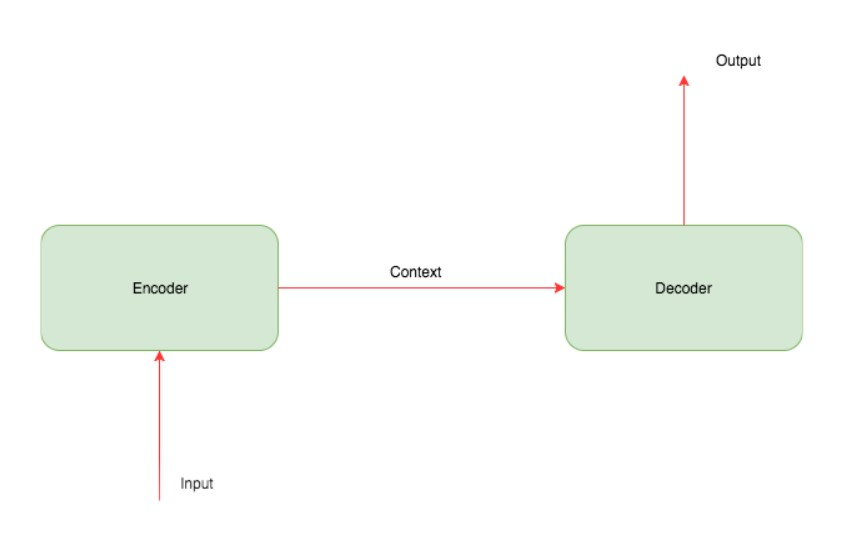

In [10]:
Image("img/encoder_decoder.jpg")

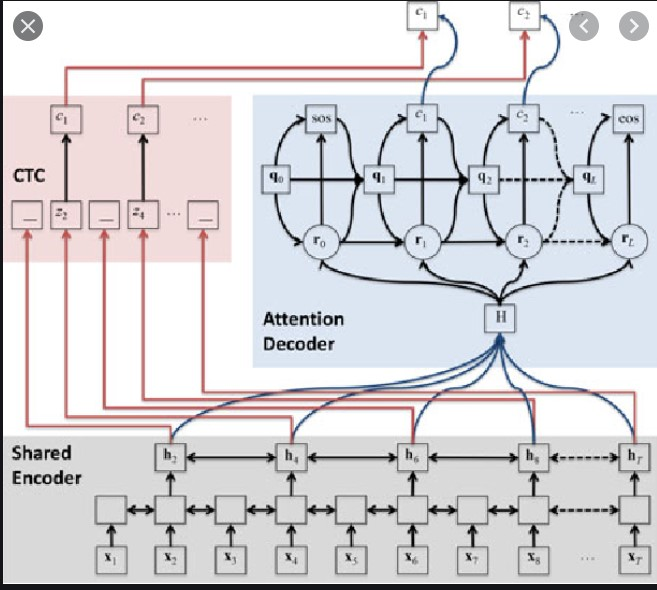

In [16]:
Image("img/hybrid_ctc_attn.jpg")

### 4.1 Encoder

Pellentesque vestibulum justo nisl, at consectetur magna ultrices iaculis. Cras quis nunc accumsan, consectetur dolor eleifend, condimentum dolor. Phasellus accumsan ullamcorper est, quis tempor ipsum lacinia non. Suspendisse potenti. Donec iaculis quam finibus, fringilla risus vestibulum, consequat dui. Phasellus fringilla augue at urna pharetra venenatis. Aliquam tempor sagittis est, et feugiat velit. Proin molestie, nulla ac rhoncus venenatis, orci nisi sollicitudin risus, finibus semper dui ex eu leo.


#### 4.1.1 Encoder RNN

Donec iaculis quam rhoncus lorem dignissim venenatis. Morbi metus odio, ornare a dui sed, volutpat malesuada eros. Curabitur sit amet pellentesque eros, nec lacinia sem. Pellentesque vulputate, mauris ac sollicitudin efficitur, ante lacus auctor arcu, sit amet suscipit ligula nunc fringilla dolor. Donec sit amet neque eget nisi posuere blandit vitae ac ante. Nulla leo ipsum, hendrerit in enim at, pharetra posuere quam. Suspendisse luctus varius dui id pellentesque. Nam tincidunt volutpat turpis, ut commodo magna efficitur ac. Ut ornare ante id nibh bibendum, a semper ipsum condimentum. Sed vitae sollicitudin felis. Sed eget ante aliquam, fermentum felis auctor, vestibulum ipsum. Nam gravida libero vitae mi accumsan tempor. Nullam placerat sed metus imperdiet lobortis. Curabitur bibendum est dolor, nec lobortis odio vehicula a.



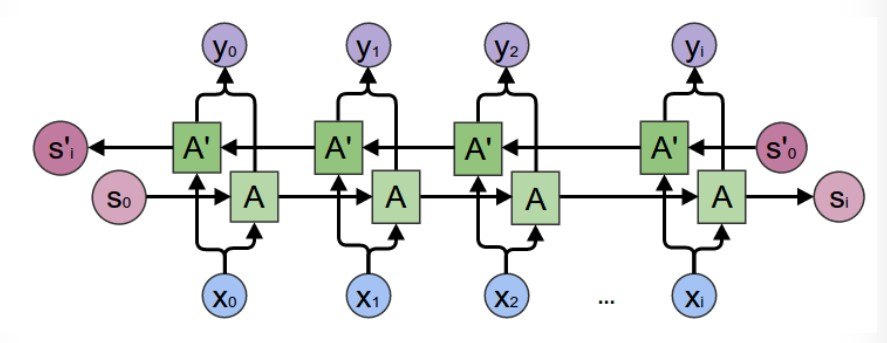

In [11]:
Image("img/bilstm.jpg")

#### 4.1.2 Encoder VGGLike+RNN

Vivamus rhoncus vitae enim a rutrum. Curabitur porta dolor nec egestas auctor. Mauris luctus arcu et purus pharetra euismod. Aliquam porttitor felis risus, et sollicitudin magna sodales a. Etiam turpis massa, bibendum nec gravida in, elementum et elit. In tortor mi, rutrum eget nisl sit amet, pharetra cursus nisi. In dignissim, nunc sed ultrices mollis, felis nisl ultricies urna, at efficitur dui lectus et nisi. Vivamus quis ornare mi. Duis massa mauris, tempor sit amet bibendum quis, fermentum eget nisi.



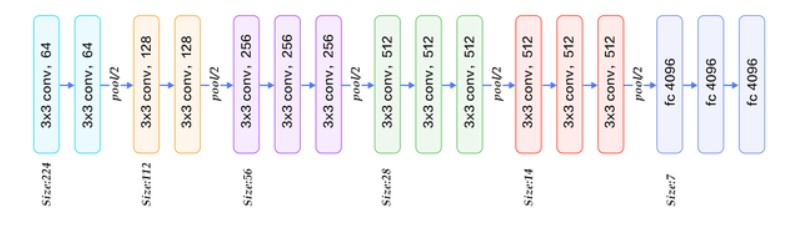

In [12]:
Image("img/vgg.jpg")

#### 4.1.3 Encoder Transformer

Phasellus congue mi in ante tempor convallis. Proin condimentum pellentesque lacus, vitae egestas sem pulvinar vitae. Morbi eu neque ut erat ullamcorper elementum. Fusce vel ipsum leo. Interdum et malesuada fames ac ante ipsum primis in faucibus. Maecenas eget placerat augue, sit amet dictum risus. Quisque gravida tellus sit amet quam ultricies, vel scelerisque dui sollicitudin.



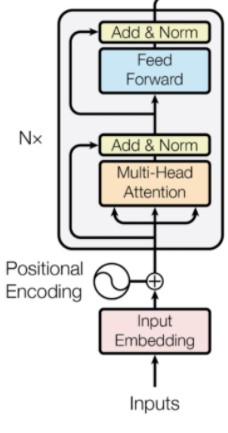

In [4]:
Image("img/img_encoder_transformer.jpg")

### 4.2 Decoder

Morbi quis est accumsan, semper quam in, dapibus est. Mauris quis egestas quam. Morbi vestibulum elit nec lectus vestibulum condimentum. Duis finibus lectus sed venenatis mattis. Sed in feugiat felis, ut semper diam. Suspendisse tincidunt sit amet justo nec fermentum. Nam eleifend ante sed leo blandit, a aliquam tortor venenatis. Pellentesque tristique porta lorem et sollicitudin.



#### 4.2.1 Decoder RNN+att

Vivamus rhoncus vitae enim a rutrum. Curabitur porta dolor nec egestas auctor. Mauris luctus arcu et purus pharetra euismod. Aliquam porttitor felis risus, et sollicitudin magna sodales a. Etiam turpis massa, bibendum nec gravida in, elementum et elit. In tortor mi, rutrum eget nisl sit amet, pharetra cursus nisi. In dignissim, nunc sed ultrices mollis, felis nisl ultricies urna, at efficitur dui lectus et nisi. Vivamus quis ornare mi. Duis massa mauris, tempor sit amet bibendum quis, fermentum eget nisi.



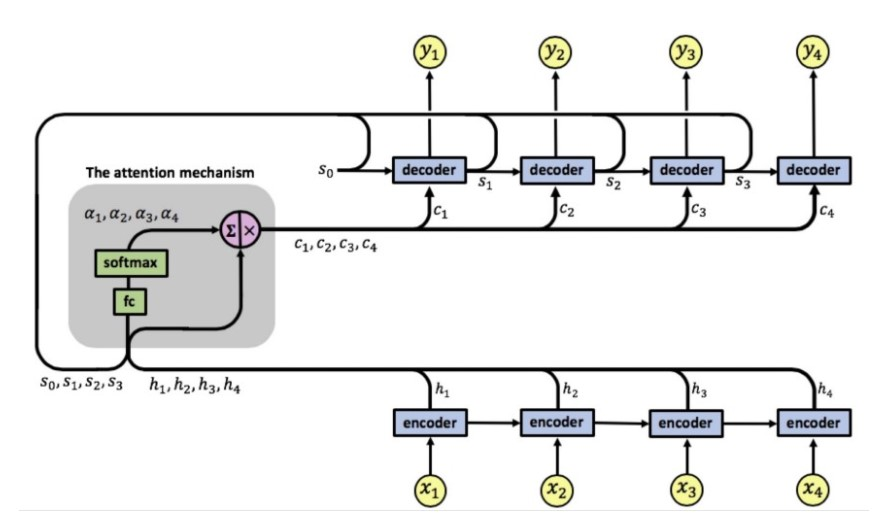

In [14]:
Image("img/rnn_att.jpg")

#### 4.2.2 Decoder Transformer

Morbi quis est accumsan, semper quam in, dapibus est. Mauris quis egestas quam. Morbi vestibulum elit nec lectus vestibulum condimentum. Duis finibus lectus sed venenatis mattis. Sed in feugiat felis, ut semper diam. Suspendisse tincidunt sit amet justo nec fermentum. Nam eleifend ante sed leo blandit, a aliquam tortor venenatis. Pellentesque tristique porta lorem et sollicitudin.




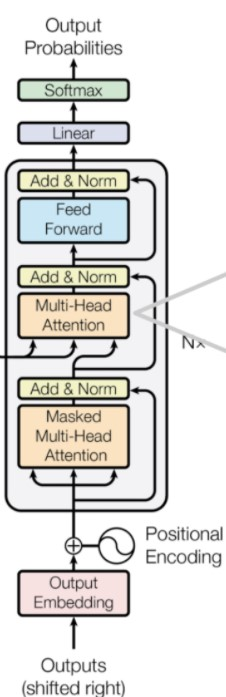

In [13]:
Image("img/img_decoder_transformer.jpg")

### 4.3 CTC Connectionist temporal Classification

Lorem ipsum dolor sit amet, consectetur adipiscing elit. Fusce vitae hendrerit est, ut maximus dui. Vivamus at eros sapien. Nullam tempus nunc a odio faucibus, nec mollis arcu accumsan. Pellentesque nec congue mauris, ac pretium purus. Pellentesque fringilla dignissim mollis. In eu congue lacus. Donec finibus risus vitae condimentum euismod. Aenean vitae viverra augue. Sed vel semper tellus, sed molestie sapien. Lorem ipsum dolor sit amet, consectetur adipiscing elit. Maecenas id ipsum vestibulum, ultrices sapien id, dapibus dui. Class aptent taciti sociosqu ad litora torquent per conubia nostra, per inceptos himenaeos. Praesent ut semper nisi, malesuada egestas est. Mauris nec eros nulla.



#### 4.3.1 BILSTM

Morbi quis est accumsan, semper quam in, dapibus est. Mauris quis egestas quam. Morbi vestibulum elit nec lectus vestibulum condimentum. Duis finibus lectus sed venenatis mattis. Sed in feugiat felis, ut semper diam. Suspendisse tincidunt sit amet justo nec fermentum. Nam eleifend ante sed leo blandit, a aliquam tortor venenatis. Pellentesque tristique porta lorem et sollicitudin.



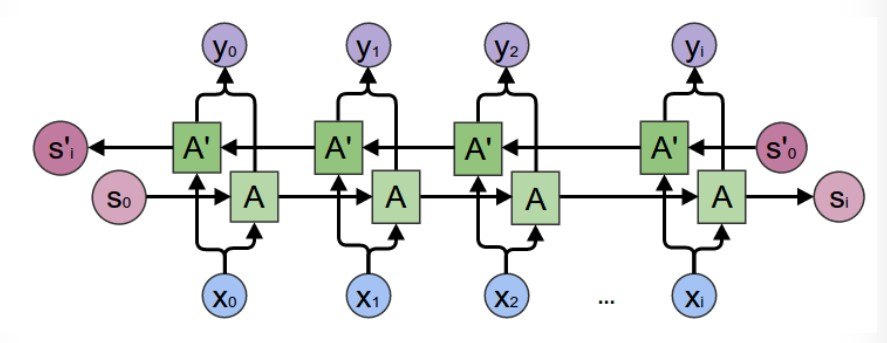

In [5]:
Image("img/bilstm.jpg")

#### 4.3.2 CTC Loss

Maecenas sed nulla at ex scelerisque commodo a nec diam. Suspendisse pulvinar maximus odio, eu rhoncus dolor aliquet ornare. Nullam convallis quam a ipsum ultrices aliquet. Maecenas ut augue a eros mattis dictum vitae eget metus. Ut posuere elit vel dui aliquam scelerisque. Etiam fermentum enim at luctus consectetur. Morbi id molestie odio.



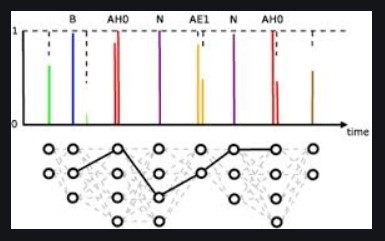

In [9]:
Image("img/ctc_loss.jpg")

##### 4.3.2.1 Trellis

Etiam faucibus, mauris nec luctus commodo, lectus lectus porta mauris, sed auctor turpis purus sagittis nunc. Aliquam risus nisi, dapibus a velit eget, luctus facilisis urna. Proin a lorem orci. Duis eu fringilla erat. Nunc non eleifend nibh, vulputate dignissim odio. Suspendisse potenti. Praesent ut condimentum lectus. Nulla facilisi. Aliquam quis est eleifend, imperdiet purus auctor, dapibus sem. Morbi ac ornare nulla, pharetra venenatis est. Mauris lobortis urna lorem, dictum faucibus erat consequat a. Nam faucibus, elit eget varius finibus, ex mauris viverra justo, a imperdiet urna arcu eget dolor. Praesent quis odio enim. Fusce tristique maximus arcu, vel posuere purus consectetur eu.

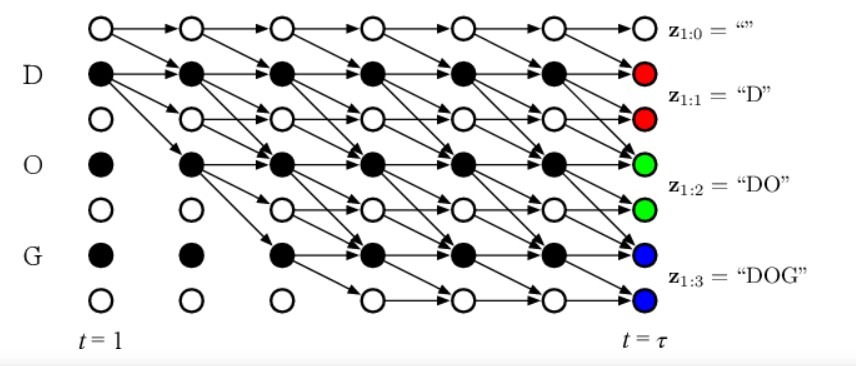

In [6]:
Image("img/trellis.jpg")

##### 4.3.2.2 Dynamic Programming

Pellentesque habitant morbi tristique senectus et netus et malesuada fames ac turpis egestas. Etiam at ornare sem. Nullam tincidunt vestibulum justo hendrerit consectetur. Vestibulum congue quam est, ut venenatis massa dictum sit amet. Etiam id blandit leo, laoreet consectetur nisl. Nullam suscipit, risus in aliquam aliquam, metus eros congue massa, ac porttitor quam tellus quis nunc. Vestibulum ante ipsum primis in faucibus orci luctus et ultrices posuere cubilia curae; Vivamus porta volutpat faucibus. Curabitur sem eros, tristique et lectus sed, venenatis bibendum orci. Fusce imperdiet at eros at molestie.


(https://m.blog.naver.com/sogangori/221183469708)

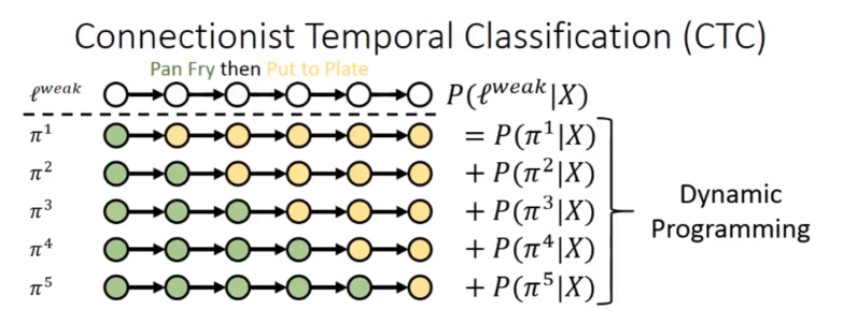

In [7]:
Image("img/dynamic_programming_ctc.jpg")

### 4.4 Attention

Etiam faucibus, mauris nec luctus commodo, lectus lectus porta mauris, sed auctor turpis purus sagittis nunc. Aliquam risus nisi, dapibus a velit eget, luctus facilisis urna. Proin a lorem orci. Duis eu fringilla erat. Nunc non eleifend nibh, vulputate dignissim odio. Suspendisse potenti. Praesent ut condimentum lectus. Nulla facilisi. Aliquam quis est eleifend, imperdiet purus auctor, dapibus sem. Morbi ac ornare nulla, pharetra venenatis est. Mauris lobortis urna lorem, dictum faucibus erat consequat a. Nam faucibus, elit eget varius finibus, ex mauris viverra justo, a imperdiet urna arcu eget dolor. Praesent quis odio enim. Fusce tristique maximus arcu, vel posuere purus consectetur eu.


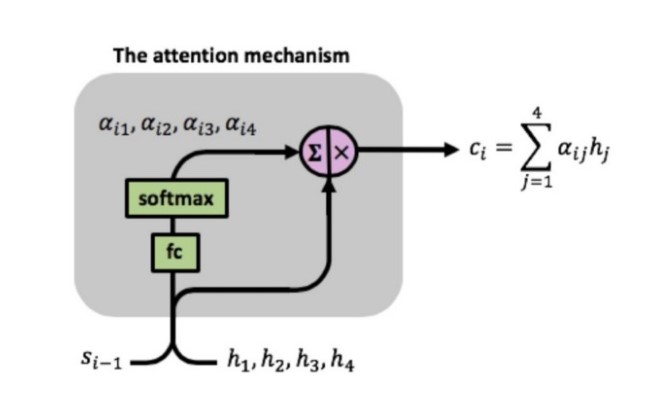

In [15]:
Image("img/attn.jpg")

#### 4.4.1 Transformer attention

Morbi quis est accumsan, semper quam in, dapibus est. Mauris quis egestas quam. Morbi vestibulum elit nec lectus vestibulum condimentum. Duis finibus lectus sed venenatis mattis. Sed in feugiat felis, ut semper diam. Suspendisse tincidunt sit amet justo nec fermentum. Nam eleifend ante sed leo blandit, a aliquam tortor venenatis. Pellentesque tristique porta lorem et sollicitudin.


##### 4.4.1.1 Dot Product Attention

Maecenas sed nulla at ex scelerisque commodo a nec diam. Suspendisse pulvinar maximus odio, eu rhoncus dolor aliquet ornare. Nullam convallis quam a ipsum ultrices aliquet. Maecenas ut augue a eros mattis dictum vitae eget metus. Ut posuere elit vel dui aliquam scelerisque. Etiam fermentum enim at luctus consectetur. Morbi id molestie odio.


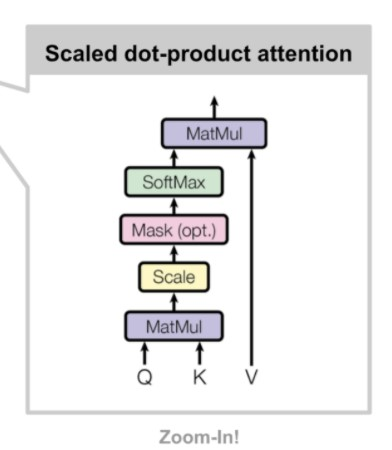

In [17]:
Image("img/img_dot_prod_attn.jpg")

##### 4.4.1.2 Multihead Attention

Vivamus rhoncus vitae enim a rutrum. Curabitur porta dolor nec egestas auctor. Mauris luctus arcu et purus pharetra euismod. Aliquam porttitor felis risus, et sollicitudin magna sodales a. Etiam turpis massa, bibendum nec gravida in, elementum et elit. In tortor mi, rutrum eget nisl sit amet, pharetra cursus nisi. In dignissim, nunc sed ultrices mollis, felis nisl ultricies urna, at efficitur dui lectus et nisi. Vivamus quis ornare mi. Duis massa mauris, tempor sit amet bibendum quis, fermentum eget nisi.



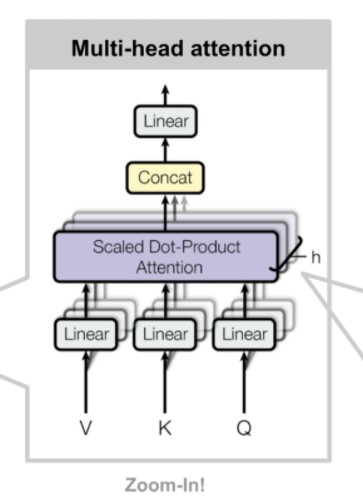

In [18]:
Image("img/img_mha.jpg")

## 5 Treinamentos

Falar sobre todos os treinamentos de todos os conjuntos de dados, mostrar as figuras de acc, loss, loss_att, loss_ctc, e resultados (pegar tudo do tensorboard e dos logs do espnet)

Minhas sugestões (Andre)

Treinamentos com todos os conjuntos de dados (talvez exceto o alcaim) os modelos descritos acima (RNN, VGGRNN e Transformer)

Treinar todas essas opções de modelo+dataset com as features extraídas do kaldi, com raw_audio e com o frontend do espnet (que usa seu proprio fbank e nao usa o parâmetro pitch)
        
        

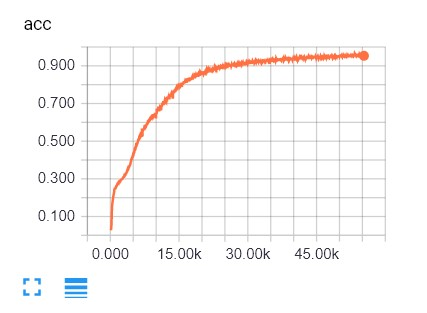

In [23]:
Image("img/acc_exemplo.jpg")

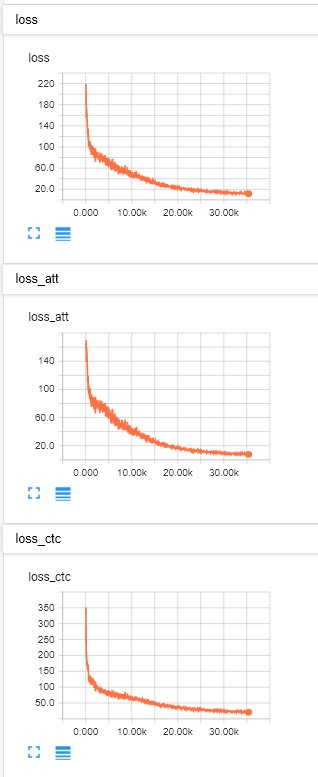

In [24]:
Image("img/loss_exemplo.jpg")

## 5 Exemplo step-by-step

In [ ]:
#a classe ASRDecoder talvez seja parecida com isso
fbank_pitch = asr_decoder.extract_fbank_pitch(audiofile)
fbank_pitch.shape

batch_fbank_pitch = asr_decoder.batchfy(fbank_pitch)

encoded = asr_decoder.encode(batch_fbank_pitch)

hypothesis = asr_decoder.beam_search(encoded)

asr_decoder.plot_ctc(encoded)

asr_decoder.plot_all_attentions(encoded)

### 5.1 Carrega Audio

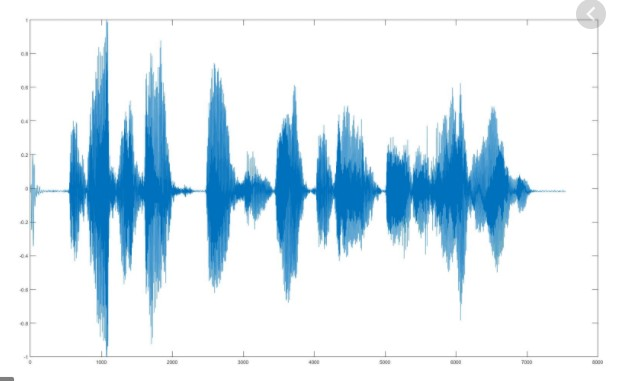

In [26]:
Image("img/audio_signal.jpg")

### 5.2 Extrai Features

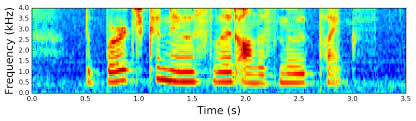

In [27]:
Image("img/featured_signal.jpg")

### 5.3 Mostrar o vetor de embeddings

### 5.4 Attention Weights


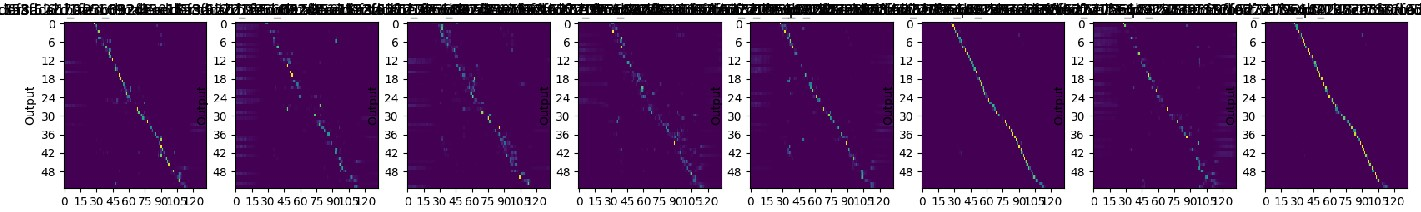

In [28]:
Image("img/att_ws.jpg")

### 5.5 CTC Posteriors



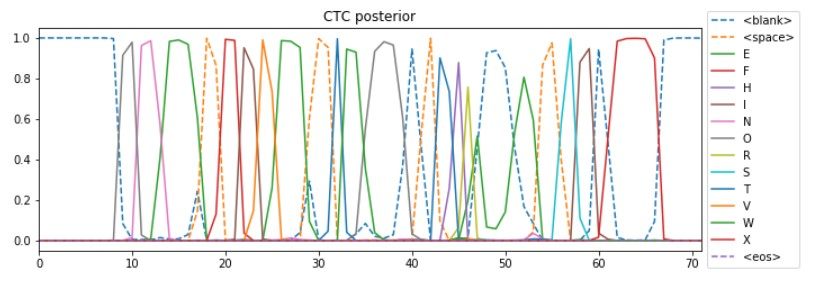

In [29]:
Image("img/ctc_posteriors.jpg")

### 5.6 BeamSearch, Hipoteses e Resultados

##  6 Considerações

### 6.1 Complexidade O(n2) no decoder transformer

### 6.2 Qualquer outra coisa